# Face-Mask-Classification Project


Authors:
+ Tobias Palmowski
+ Fabian Metz
+ Thilo Sander

Date of Midterm-Report: 29.03.2021 <br>
Date of final submission: 26.04.2021


### Introduction

This Jupyter Notebook is the core of the Face-Mask-Classification Project performed in the class "Machine Learning" of the Hertie School in Berlin. There is one other Jupyter Notebook which deals with combining the different datasets into one large data set - a task only performed once and therefore outsourced to another file.

The following code is losely based on the chapter "Classification" from the book "Hands-on Machine Learning with Scikit-Learn, Keras, and Tensorflow" by Aurélien Géron.

We included several hints were we are working on in yellow warning boxes.

<br>
<br>
<br>
<br>

### Preparation

<br>
This part loads the necessary libraries and packages as well as setting the Input and Output Directories.

In [221]:
# Import necessary libraries and set-up Jupyter NoteMasked-Face-Net-Datasetbook.

# Common imports
import numpy as np
import pandas as pd
import os
import seaborn as sns # for plotting
import matplotlib.pyplot as plt # for plotting
import timeit # To keep track of calculation time
import PIL #Python Image Library
import pickle

# to make this notebook's output stable across runs (safety measure)
np.random.seed(42)

In [222]:
# Switch between toy and full data
full_data_switch_on = False #Set True for full data set and False for Dummy Data set (see comment below)

<div class="alert alert-block alert-danger">
<b>Action required</b>
<p>
    
You have to set the switch whether you want to use the full dataset (True) or the dummy toy dataset (False). We set aside 100 correct and 100 incorrect pictures into a dummy toy data set in order to test our code faster. For running the algorithm with the dummy toy data everything is included in the GitHub-Repository (in the folder "01_data/99_dummy_toy_data"). The corresponding .pkl-file that include the output of the first Jupyter Notebook is included in the repository as well (in the folder "01_data/01_cleaned/")
    
However, if you want to run the algorithm with the full data set, you have to download the corresponding files under the Dropbox-Link below. The raw data is placed in the Dropbox folder "00_raw" (Hint: It is ca. 40,5 GB) and you have to download it into the repository folder "01_data/00_raw/". The corresponding pickle files depending on the pixel resolution you choose (see code at bottom of Jupyter Notebook) are several GB big and are also available in the Dropbox-Folder under "01_cleaned". This file has to be placed in the corresponding repository folder "01_data/01_cleaned/" to make this code run .

The reason why we cannot directly use the links here is that we do not have figured out yet how to loop through subfolders and files Dropbox online. GitHub does not allow us to upload such an amount of data.
<br>
Dropbox-Link: https://www.dropbox.com/sh/45vbkq1ihfnhqem/AAADdq6mJKaLsG1w7SDK-QV8a?dl=0    

<br>
<b>
!!!  Be aware: Running this Jupyter Notebook with the full data set requires several hours of runtime depending on your hardware !!!

</b>    
</div>

In [223]:
# Defining path to cleaned data folder
PATH_CLEANED_DATA = "01_data/01_cleaned"

# Where to save figures
ROOT_FIGS = "02_figures"
TOPIC_ID = "02_baseline"
IMAGES_PATH = os.path.join(ROOT_FIGS, TOPIC_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

CM_IMAGES_PATH = os.path.join(IMAGES_PATH, "Confusion_Matrices")
os.makedirs(CM_IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, SAVE_PATH=IMAGES_PATH, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(SAVE_PATH, fig_id + "." + fig_extension)
    print(">... Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Where to save general output (not figures)
ROOT_OUTPUT = "03_output"
TOPIC_ID = "01_eval_scores"
OUTPUT_PATH_EVAL = os.path.join(ROOT_OUTPUT, TOPIC_ID)
os.makedirs(OUTPUT_PATH_EVAL, exist_ok=True)

TOPIC_ID2 = "02_error_tables"
OUTPUT_PATH_ERROR_TABLES = os.path.join(ROOT_OUTPUT, TOPIC_ID2)
os.makedirs(OUTPUT_PATH_ERROR_TABLES, exist_ok=True)

<br>
<br>
<br>
<br>

## Functions

<br>
This part defines all necessary functions used in the notebook

#### Test/Show available pixel resolutions

In [224]:
# Show available pixel resolutions
def show_avail_pixels():    
    # List all files in cleaned data folder
    filenames = []
    for root, dirs, files in os.walk(PATH_CLEANED_DATA):
        for name in files:
            filenames.append(os.path.join(root, name))
    
    # Separate filenames of dummy toy and full data set (and extacting available pixels)        
    pixels_dummy_toy = []
    pixels_full = []
    for i in range(len(filenames)):
        if "dummy_toy" in filenames[i]:
            # Find pixel resolution in filenames
            search_term = "dummy_toy_"
            pos_start = filenames[i].find(search_term)
            pos_end = filenames[i].find(".")
            help_length = len(search_term) #To add on starting posting
            pixel_string = filenames[i][pos_start+help_length:pos_end]
            # Append pixel resolutions to list
            pixels_dummy_toy.append(pixel_string)
        elif "full" in filenames[i]:
            # Find pixel resolution in filenames
            search_term = "full_"
            pos_start = filenames[i].find(search_term)
            pos_end = filenames[i].find(".")
            help_length = len(search_term) #To add on starting posting
            pixel_string = filenames[i][pos_start+help_length:pos_end]
            # Append pixel resolutions to list
            pixels_full.append(pixel_string)
        else:
            raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")
    
    # Transforming pixel resolution strings into integers and sorting
    for itr in range(len(pixels_dummy_toy)):
        pixels_dummy_toy[itr] = int(pixels_dummy_toy[itr])
    pixels_dummy_toy.sort()
    pixels_full = [int(i) for i in pixels_full]
    pixels_full.sort()
    
    # Output depending on switch
    if full_data_switch_on == True:
        print("The following pixels are available for the full data set: ", pixels_full)
        return pixels_full
    elif full_data_switch_on == False:
        print("The following pixels are available for the dummy toy data set: ", pixels_dummy_toy)
        return pixels_dummy_toy
    else:
        raise ValueError("Full data switch not correctly defined: Binary value of True or False necessary")

In [225]:
# Define Check of pixel resolutions
def check_pixels(pix_res):
    avail_pixels = show_avail_pixels()
    if pix_res in avail_pixels:
        print("The specified pixel resolution {} is available!".format(pix_res))
    else:
        raise ValueError("The specified pixel resolution {} is not available! See available pixel resolutions above error message.".format(pix_res))

<br>
<br>
<br>
<br>
<br>
<br>

#### Load and split specified data set

In [226]:
# Definition of function to load corresponding pixel resolution file
def load_data(pix_res):
    # Define datafile path
    if full_data_switch_on == True:
        DATAFILE_PATH = os.path.join(PATH_CLEANED_DATA + "/pic_data_full_" + str(pix_res) + ".pkl")
    elif full_data_switch_on == False:
        DATAFILE_PATH = os.path.join(PATH_CLEANED_DATA + "/pic_data_dummy_toy_" + str(pix_res) + ".pkl")
    else:
        raise ValueError("Full data switch not correctly defined: Binary value of True or False necessary")
    
    # Load pickle file
    pic_data = pickle.load(open(DATAFILE_PATH,"rb"))
    print(">... Pickle datafile successfully loaded: ", DATAFILE_PATH)
    
    # Copying dictionary data into separate data frames
    rgb_data, labels, pic_ids = pic_data["rgb_data"], pic_data["labels"], pic_data["pic_ids"]
    print(">... Pickle dictionary sucessfully separated into individuals arrays")
    
    # Split into test and training data set
    from sklearn.model_selection import train_test_split
    rgb_data_train, rgb_data_test, labels_train, labels_test, pic_ids_train, pic_ids_test = train_test_split(rgb_data, labels, pic_ids, test_size=0.10, random_state=42)
    print(">... Data sucessfully split into test and train data")
    
    # redefining labels as True False
    labels_train_tf = (labels_train == 1)
    labels_test_tf = (labels_test == 1)
    
    return rgb_data_train, rgb_data_test, labels_train_tf, labels_test_tf, pic_ids_train, pic_ids_test
    

<br>
<br>
<br>
<br>
<br>
<br>

#### Train specified classifier on data set

In [227]:
# Definition of function that trains classifier on specified data set
def train_clasf(classifier_x, rgb_train, labels_train, pixel_res):
    #Start timer
    start_time = timeit.default_timer()
    
    # Set classifier name and print status
    classifier_name = str(classifier_x) # set classifier names
    classifier_name = classifier_name[:classifier_name.find("(")] 
    print(">... Starting", classifier_name)
    
    #Train model
    classifier_x.fit(rgb_train, labels_train)
    
    # Stop timer:
    time_elapsed = timeit.default_timer() - start_time
    
    # Store run-time info
    run_time_info = {}
    run_time_info[str(pixel_res)] = round(time_elapsed, 2)
    if full_data_switch_on == True:
        file = open(("03_output/01_eval_scores/run_time_train_full_"+str(classifier_name)+"_"+str(pixel_res)+".pkl"),"wb")
        pickle.dump(run_time_info, file)
        file.close()
        print("Successfully stored in: 03_output/01_eval_scores/run_time_train_full_"+str(classifier_name)+"_"+str(pixel_res)+".pkl")
    elif full_data_switch_on == False:
        file = open(("03_output/01_eval_scores/run_time_train_dummy_toy_"+str(classifier_name)+"_"+str(pixel_res)+".pkl"),"wb")
        pickle.dump(run_time_info, file)
        file.close()
        print("Successfully stored in: 03_output/01_eval_scores/run_time_train_dummy_toy_"+str(classifier_name)+"_"+str(pixel_res)+".pkl")
    else:
        raise ValueError("Full data switch not correctly defined: Binary value of True or False necessary")
    
    print(">... Classifier {} sucessfully trained in {} seconds.".format(classifier_name, round(time_elapsed,2)))

<div class="alert alert-block alert-warning">
<b>CHECK WITH ALL</b>
<p>
    
Do we really need this function?
</div>

<br>
<br>
<br>
<br>
<br>
<br>

#### Evaluate specified classifier on specified data

In [228]:
# Define Evaluation function
def eval_clasf(classifier_x, rgb_data, labels, pic_ids, pix_res):
    # Import metrics and validation methods
    from sklearn.model_selection import cross_val_score, cross_val_predict
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, plot_confusion_matrix, precision_recall_curve
    import matplotlib.pyplot as plt 
    
    # Start timer
    start_time = timeit.default_timer()
    # Set classifier name and print status
    classifier_name = str(classifier_x) # set classifier names
    classifier_name = classifier_name[:classifier_name.find("(")] 
    print(">... Starting evaluation of", classifier_name)
    
    # Evaluate classifier
    print(">... Starting cross validation of", classifier_name)
    pred=cross_val_predict(classifier_x, rgb_data, labels, cv = 3) # cross value prediction with 3 folds
    
    
    # Store evaluation metrics
    print(">... Saving evaluation metric of", classifier_name)
    # Running cross validation score
    cvs = cross_val_score(classifier_x, rgb_data, labels, cv=3, scoring="accuracy").round(3)
    # Initialize eval dictionary and store values
    evaluation_scores = {}
    evaluation_scores["Precision Score"] = precision_score(labels, pred).round(3)
    evaluation_scores["Recall Score"] = recall_score(labels, pred).round(3)
    evaluation_scores["Confusion matrix"] = confusion_matrix(labels, pred)
    evaluation_scores["Cross Validation Accuracy Scores"] = cvs
    evaluation_scores["Cross Validation Accuracy Score Mean"] = cvs.mean().round(3)
    evaluation_scores["Cross Validation Accuracy Score Std"] = cvs.std().round(5)
  
    
    # Data for Precision recall curve //RandomForestClassifier //DecisionTreeClassifier
    if classifier_name ==  'SGDClassifier':
        print(">... Saving precision, recalls and thresholds of", classifier_name)
        decision_scores = cross_val_predict(classifier_x, rgb_data, labels, cv = 3, method="decision_function")
        precisions, recalls, thresholds = precision_recall_curve(labels,decision_scores)
        #storing precision reacall and treshold values in eval directory
        evaluation_scores["Precisions"] = precisions
        evaluation_scores["Recalls"] = recalls
        evaluation_scores["Thresholds"] = thresholds
    elif classifier_name == 'LinearSVC':
        print(">... Saving precision, recalls and thresholds of", classifier_name)
        decision_scores = cross_val_predict(classifier_x, rgb_data, labels, cv = 3, method="decision_function")
        precisions, recalls, thresholds = precision_recall_curve(labels,decision_scores)
        #storing precision reacall and treshold values in eval directory
        evaluation_scores["Precisions"] = precisions
        evaluation_scores["Recalls"] = recalls
        evaluation_scores["Thresholds"] = thresholds
    else:
         print (">... Precision-recall-curve not applicable for this classifier")
    
    # Stop timer:
    time_elapsed = timeit.default_timer() - start_time
    evaluation_scores["Evaluation run-time in seconds"] = round(time_elapsed, 2)
    
    # Storing evaluations scores into pickle file to access them later
    if full_data_switch_on == True: 
        EVAL_FILE_PATH = os.path.join(OUTPUT_PATH_EVAL + "/evaluation_scores_" + str(classifier_name) + "_full_" + str(pix_res) + ".pkl")
    elif full_data_switch_on == False:
        EVAL_FILE_PATH = os.path.join(OUTPUT_PATH_EVAL + "/evaluation_scores_" + str(classifier_name) + "_dummy_toy_" + str(pix_res) + ".pkl")
    else:
        raise ValueError("Full data switch not correctly defined: Binary value of True or False necessary")
    file = open(EVAL_FILE_PATH,"wb")
    pickle.dump(evaluation_scores, file)
    file.close()
    print(">... Evaluation scores successfully stored in: {}".format(EVAL_FILE_PATH))
    
    
    # Create output array with error-types and pic ids
    # Combine pics ids, labels and predicted values
    print(">... Starting to create output array with error-types for more transparency for classifier {}.".format(classifier_name))
    output_dict = {}
    output_array = np.c_[pic_ids, labels, pred]
    
    # Create error array with specific error type
    err_type_arr = np.array([])
    for i in range(len(output_array)):
        if output_array[i,1] == "True" and output_array[i,2] == "False":
            err_type_arr = np.append(err_type_arr, "False negative")
        elif output_array[i,1] == "False" and output_array[i,2] == "True":
            err_type_arr = np.append(err_type_arr, "False positive")
        else:
            err_type_arr = np.append(err_type_arr, "No error")
    
    # Combine error into and output array into pandas data frame
    error_table_pd = pd.DataFrame(output_array)
    error_table_pd.rename(columns = {0:'Filename picture ID', 1:"Label", 2:"Predicted"}, inplace = True)
    error_table_pd["Error Type"] = err_type_arr
    
    # Saving all in dictionary
    output_dict["error_table"] = error_table_pd
    
    # Saving dictionary of error table
    if full_data_switch_on == True: 
        ERROR_TABLE_FILE_PATH = os.path.join(OUTPUT_PATH_ERROR_TABLES + "/error_table_pd_" + str(classifier_name) + "_full_" + str(pix_res) + ".pkl")
    elif full_data_switch_on == False:
        ERROR_TABLE_FILE_PATH = os.path.join(OUTPUT_PATH_ERROR_TABLES + "/error_table_pd_" + str(classifier_name) + "_dummy_toy_" + str(pix_res) + ".pkl")
    else:
        raise ValueError("Full data switch not correctly defined: Binary value of True or False necessary")
    file = open(ERROR_TABLE_FILE_PATH,"wb")
    pickle.dump(output_dict, file)
    file.close()
    print(">... Error table dictionary successfully stored in: {}".format(ERROR_TABLE_FILE_PATH))
    
    
    # Output message
    print(">... Evaluation of classifier {} sucessfully finished in {} seconds.".format(classifier_name, round(time_elapsed,2)))


<br>
<br>
<br>
<br>
<br>
<br>

#### Define showing output functions

In [229]:
# Defining function that shows and stores all showable outputs
def show_evals(pix_res, error_table=True, conf_matrix=True, eval_metrics=True):

    
    ###### Error Table ######
    if error_table == True:
        # List all files of error table folder
        filenames_error_table = []
        for root, dirs, files in os.walk(OUTPUT_PATH_ERROR_TABLES):
            for name in files:
                filenames_error_table.append(os.path.join(root, name))
        
        # Select all filenames corresponding to pixel size
        filenames_error_table_pix = []
        for i in range(len(filenames_error_table)):
            if str(pix_res) in filenames_error_table[i]:
                filenames_error_table_pix.append(filenames_error_table[i])
        
        # Display error table
        for i in range(len(filenames_error_table_pix)):
            # Extract classifier name from filename
            if "dummy_toy" in filenames_error_table_pix[i]:
                # Find pixel resolution in filenames
                search_term = "error_table_pd_"
                pos_start = filenames_error_table_pix[i].find(search_term)
                pos_end = filenames_error_table_pix[i].find("_dummy_toy_")
                help_length = len(search_term) #To add on starting posting
                classifier_name = filenames_error_table_pix[i][pos_start+help_length:pos_end]
            elif "full" in filenames_error_table_pix[i]:
                # Find pixel resolution in filenames
                search_term = "error_table_pd_"
                pos_start = filenames_error_table_pix[i].find(search_term)
                pos_end = filenames_error_table_pix[i].find("_full_")
                help_length = len(search_term) #To add on starting posting
                classifier_name = filenames_error_table_pix[i][pos_start+help_length:pos_end]
            else:
                raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")
            
            # Load pickle-file and display pandas data frame filtered to error types
            dict_error_table = pickle.load(open(filenames_error_table_pix[i],"rb"))
            print(">... Error table pickle file successfully loaded for {} and pixel resolution {}".format(classifier_name, pix_res))
            error_table_pd = dict_error_table["error_table"]
            filter_options = ["False positive", "False negative"]
            print(">... Print error table for pixel resolution {} of {}\n\n".format(pix_res, classifier_name))
            print(error_table_pd.loc[error_table_pd["Error Type"].isin(filter_options)].sort_values(by=["Label", "Filename picture ID"]))
            print("\n\n")
    
    elif error_table == False:
        print("Error Table for pixel resolution {} not selected by user.".format(pix_res))
    else:
        raise ValueError("Check parameter 'error_table': Has to be binary True or False")

        
    ###### Confusion Matrix ######
    if conf_matrix == True:
        # List all files of eval dictionary folder
        filenames_eval_dics = []
        for root, dirs, files in os.walk(OUTPUT_PATH_EVAL):
            for name in files:
                filenames_eval_dics.append(os.path.join(root, name))
        
        # Select all filenames corresponding to pixel size
        filenames_eval_dics_pix = []
        for i in range(len(filenames_eval_dics)):
            if str(pix_res) in filenames_eval_dics[i]:
                filenames_eval_dics_pix.append(filenames_eval_dics[i])
        
        # Display confusion matrix
        for i in range(len(filenames_eval_dics_pix)):
            # Extract classifier name from filename
            if "dummy_toy" in filenames_eval_dics_pix[i]:
                # Find pixel resolution in filenames
                search_term = "evaluation_scores_"
                pos_start = filenames_eval_dics_pix[i].find(search_term)
                pos_end = filenames_eval_dics_pix[i].find("_dummy_toy_")
                help_length = len(search_term) #To add on starting posting
                classifier_name = filenames_eval_dics_pix[i][pos_start+help_length:pos_end]
            elif "full" in filenames_eval_dics_pix[i]:
                # Find pixel resolution in filenames
                search_term = "evaluation_scores_"
                pos_start = filenames_eval_dics_pix[i].find(search_term)
                pos_end = filenames_eval_dics_pix[i].find("_full_")
                help_length = len(search_term) #To add on starting posting
                classifier_name = filenames_eval_dics_pix[i][pos_start+help_length:pos_end]
            else:
                raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")
        
            # Load pikle-file and display pandas data frame filtered to error types
            dict_eval_metrics = pickle.load(open(filenames_eval_dics_pix[i],"rb"))
            print(">... Eval metrics pickle file successfully loaded for {} and pixel resolution {}".format(classifier_name, pix_res))
            # Extract confusion matrix data into data frame
            cm_data = dict_eval_metrics["Confusion matrix"]
            plot_matrix = pd.DataFrame(cm_data, columns = ["classified as no mask", "classified as mask"],
                                index = ["no mask", "mask"])
            
            # Actual plot with seaborn and saving figure with different file names depending on switch
            print(">... Displaying confusion matrix for {} and pixel resolution {}".format(classifier_name, pix_res))
            if "dummy_toy" in filenames_eval_dics_pix[i]:
                plt.figure(figsize = (5,5))
                colormap = sns.color_palette("Reds")
                ax = plt.axes()
                sns.heatmap(plot_matrix, ax = ax, annot = True, fmt='d', annot_kws={"size": 20}, cmap=colormap, cbar=False)
                ax.set_title(classifier_name, fontsize= 15)
                plt.show()
                save_fig("99_CM_Toy_Dummy_{}_{}".format(classifier_name, pix_res), SAVE_PATH=CM_IMAGES_PATH)
            elif "full" in filenames_eval_dics_pix[i]:
                plt.figure(figsize = (5,5))
                colormap = sns.color_palette("Reds")
                ax = plt.axes()
                sns.heatmap(plot_matrix, ax = ax, annot = True, fmt='d', annot_kws={"size": 20}, cmap=colormap, cbar=False)
                ax.set_title(classifier_name, fontsize= 15)
                plt.show()
                save_fig("Confusion_Matrix_{}_{}".format(classifier_name, pix_res), SAVE_PATH=CM_IMAGES_PATH)
            else:
                raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")
                
    elif conf_matrix == False:
        print("Confusion matrix for pixel resolution {} not selected by user.".format(pix_res))
    else:
        raise ValueError("Check parameter 'conf_matrix': Has to be binary True or False")           
    
    
   
   

    ###### Eval Metrics ######
    if eval_metrics == True:
        # List all files of eval dictionary folder
        filenames_eval_dics = []
        for root, dirs, files in os.walk(OUTPUT_PATH_EVAL):
            for name in files:
                filenames_eval_dics.append(os.path.join(root, name))
        
        # Select all filenames corresponding to pixel size
        filenames_eval_dics_pix = []
        for i in range(len(filenames_eval_dics)):
            if str(pix_res) in filenames_eval_dics[i]:
                filenames_eval_dics_pix.append(filenames_eval_dics[i])
                
    
            
        
################################################## Further input necessary ###################################        
        eval_metrics = {}
        for i in range(len(filenames_eval_dics_pix)):
            # Extract classifier name from filename
            if "dummy_toy" in filenames_eval_dics_pix[i]:
                # Find pixel resolution in filenames
                search_term = "evaluation_scores_"
                pos_start = filenames_eval_dics_pix[i].find(search_term)
                pos_end = filenames_eval_dics_pix[i].find("_dummy_toy_")
                help_length = len(search_term) #To add on starting posting
                classifier_name = filenames_eval_dics_pix[i][pos_start+help_length:pos_end]
            elif "full" in filenames_eval_dics_pix[i]:
                # Find pixel resolution in filenames
                search_term = "evaluation_scores_"
                pos_start = filenames_eval_dics_pix[i].find(search_term)
                pos_end = filenames_eval_dics_pix[i].find("_full_")
                help_length = len(search_term) #To add on starting posting
                classifier_name = filenames_eval_dics_pix[i][pos_start+help_length:pos_end]
            else:
                raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")
            
            
            # Load pikle-file and display pandas data frame filtered to error types
            dict_eval_metrics = pickle.load(open(filenames_eval_dics_pix[i],"rb"))
            print(">... Eval metrics pickle file successfully loaded for {} and pixel resolution {}".format(classifier_name, pix_res))
            # Extract eval metrics into data frame
            precision_score = dict_eval_metrics["Precision Score"]
            recall_score = dict_eval_metrics["Recall Score"]
            cv_acc_scores = dict_eval_metrics["Cross Validation Accuracy Scores"]
            cv_acc_scores_mean = dict_eval_metrics["Cross Validation Accuracy Score Mean"]
            cv_acc_scores_std = dict_eval_metrics["Cross Validation Accuracy Score Std"]
            eval_run_time = dict_eval_metrics["Evaluation run-time in seconds"]
            
            #Storing in eval_metrics library
            eval_metrics[classifier_name] = [precision_score,
                                             recall_score,
                                             cv_acc_scores,
                                             cv_acc_scores_mean,
                                             cv_acc_scores_std,
                                             eval_run_time]
        
        # Output table of metrics
        print(">... Display eval metrics table for pixel resolution {}\n\n".format(pix_res))
        index = ["precision score", "recall score", "cross validation scores", "cross validation mean", "cross validation std", "eval run time in seconds"]
        table_eval_metrics = pd.DataFrame(eval_metrics, index)
        print(table_eval_metrics, "\n\n")  
    
    elif eval_metrics == False:
        print("Eval metrics for pixel resolution {} not selected by user.".format(pix_res))
    else:
        raise ValueError("Check parameter 'eval_metrics': Has to be binary True or False")      

        
        

In [238]:
# define function Precision Recall Plots
def show_PR_curves(pix_res,classifier_x):

    if str(classifier_x)[:str(classifier_x).find("(")] == 'SGDClassifier' or str(classifier_x)[:str(classifier_x).find("(")] == 'LinearSVC':
        ###### Precision-Recall Plots #####     
        # List all files of eval dictionary folder
        filenames_eval_dics = []
        for root, dirs, files in os.walk(OUTPUT_PATH_EVAL):
            for name in files:
                filenames_eval_dics.append(os.path.join(root, name))

        #Select all filenames corresponding to pixel size and specified classifiers
        filenames_eval_dics_pix = []
        for i in range(len(filenames_eval_dics)):
            if str(classifier_x)[:str(classifier_x).find("(")] in filenames_eval_dics[i] and str(pix_res) in filenames_eval_dics[i] and "evaluation_scores" in filenames_eval_dics[i]:
                filenames_eval_dics_pix.append(filenames_eval_dics[i])

        print(filenames_eval_dics_pix)

        eval_metrics = {}
        for i in range(len(filenames_eval_dics_pix)):
            # Extract classifier name from filename
            if "dummy_toy" in filenames_eval_dics_pix[i]:
                # Find pixel resolution in filenames
                search_term = "evaluation_scores_"
                pos_start = filenames_eval_dics_pix[i].find(search_term)
                pos_end = filenames_eval_dics_pix[i].find("_dummy_toy_")
                help_length = len(search_term) #To add on starting posting
                classifier_name = filenames_eval_dics_pix[i][pos_start+help_length:pos_end]
            elif "full" in filenames_eval_dics_pix[i]:
                # Find pixel resolution in filenames
                search_term = "evaluation_scores_"
                pos_start = filenames_eval_dics_pix[i].find(search_term)
                pos_end = filenames_eval_dics_pix[i].find("_full_")
                help_length = len(search_term) #To add on starting posting
                classifier_name = filenames_eval_dics_pix[i][pos_start+help_length:pos_end]
            else:
                raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")

            # Load pikle-file and display pandas data frame filtered to error types
            dict_eval_metrics = pickle.load(open(filenames_eval_dics_pix[i],"rb"))
            print(">... Eval metrics pickle file successfully loaded for {} and pixel resolution {}".format(classifier_name, pix_res))
            # Extract eval metrics into data frame
            print(">... Extracting Metrics into Dataframe of classifier"+str(classifier_x))
            precisions = dict_eval_metrics["Precisions"]
            recalls = dict_eval_metrics["Recalls"]
            thresholds = dict_eval_metrics["Thresholds"]

            # Plot and saving figure with different file names depending on switch
            print(">... Displaying Precision-Recall Plot for {} and pixel resolution {}".format(classifier_name, pix_res))
            if "dummy_toy" in filenames_eval_dics_pix[i]:
                plt.figure(figsize=(8,4))
                plt.plot(thresholds, precisions[:-1],"b--",label = "Precision", linewidth=2)
                plt.plot(thresholds, recalls[:-1], "g--",label = "Recall", linewidth=2)
                plt.xlabel("Threshold", fontsize = 16)
                plt.legend(loc="lower left", fontsize = 16)
                plt.ylim([0,1])
                #plt.xlim([-5,5])
                plt.show()
                #save_fig("99_PRP_Toy_Dummy_{}_{}".format(classifier_name, pix_res), SAVE_PATH=PRP_IMAGES_PATH)
            elif "full" in filenames_eval_dics_pix[i]:
                plt.figure(figsize=(8,4))
                plt.plot(thresholds, precisions[:-1],"b--",label = "Precision", linewidth=2)
                plt.plot(thresholds, recalls[:-1], "g--",label = "Recall", linewidth=2)
                plt.xlabel("Threshold", fontsize = 16)
                plt.legend(loc="lower left", fontsize = 16)
                plt.ylim([0,1])
                #plt.xlim([5,5])
                plt.show()
                #save_fig("Confusion_Matrix_{}_{}".format(classifier_name, pix_res), SAVE_PATH=PRP_IMAGES_PATH)
            else:
                raise ValueError("Check filenames! Neither 'dummy_toy' nor 'full' is in filename...")
        

<div class="alert alert-block alert-warning">
<b>TO DO</b>
<p>
    
+ Saving of plots doesn't work properly yet. It saves a figure, but with no content.
+ Displaying tables could be cooler and especially saving them would be great
</div>

<div class="alert alert-block alert-warning">
<b>ATTENTION</b>
<p>
Furhter sources for plotting things for precision and recall curves etc
</div>

 Use plot sklearn.metrics below more heavily: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics --->Plotting
 
 ---> Visualizations: https://scikit-learn.org/stable/visualizations.html#visualizations
 
 metrics.plot_confusion_matrix(estimator, X, …)
	

Plot Confusion Matrix.

metrics.plot_det_curve(estimator, X, y, *[, …])
	

Plot detection error tradeoff (DET) curve.

metrics.plot_precision_recall_curve(…[, …])
	

Plot Precision Recall Curve for binary classifiers.

metrics.plot_roc_curve(estimator, X, y, *[, …])
	

Plot Receiver operating characteristic (ROC) curve.


metrics.ConfusionMatrixDisplay(…[, …])
	

Confusion Matrix visualization.

metrics.DetCurveDisplay(*, fpr, fnr[, …])
	

DET curve visualization.

metrics.PrecisionRecallDisplay(precision, …)
	

Precision Recall visualization.

metrics.RocCurveDisplay(*, fpr, tpr[, …])
	

ROC Curve visualization.




<br>
<br>
<br>
<br>
<br>
<br>

#### Define pipeline functions for evaluation and showing

In [ ]:
# Defining pipeline function for load, training, evaluating

def load_train_eval(list_of_pixels, list_of_classifiers):
    for pix in list_of_pixels:
        print("\n\n\n>... Starting load_train_eval process for pixel resolution: {}.".format(pix))
        # Start timer pixel resolution
        start_time_pix = timeit.default_timer()
        # Test pixels
        # check_pixels(pix)
        # Load
        rgb_data_train, rgb_data_test, labels_train, labels_test, pic_ids_train, pic_ids_test = load_data(pix)

        # Run the different classifiers
        for clasf in list_of_classifiers:
            # Train
            train_clasf(clasf, rgb_data_train, labels_train, pix)
            # Evaluate
            eval_clasf(clasf, rgb_data_train, labels_train, pic_ids_train, pix)

        #End timer and output message
        elapsed_pix = timeit.default_timer() - start_time_pix
        print("\n>... Ending load_train_eval process for pixel resolution: {}. Run-time: {} seconds.".format(pix, round(elapsed_pix,2)))

# Defining pipeline function for showing evaluations
def show_evals_pipeline(list_of_pixels, list_of_classifiers, error_table_switch=False, conf_matrix_switch=False, eval_metrics_switch=False, prec_recall_plot_switch =False):
    for pix in list_of_pixels:
        print("\n\n\n>... Start showing evals for pixel resolution: {}.".format(pix))
        # Start timer pixel resolution
        start_time_pix = timeit.default_timer()
        
        # Show evals
        show_evals(pix, error_table=error_table_switch, conf_matrix=conf_matrix_switch, eval_metrics=eval_metrics_switch)
        
        # Show Precision Recall Curves
        for clasf in list_of_classifiers:
            show_PR_curves(pix, clasf)
        
        #End timer and output message
        elapsed_pix = timeit.default_timer() - start_time_pix
        print("\n>... Ending showing evals for pixel resolution: {}. Run-time: {} seconds.".format(pix, round(elapsed_pix,2)))


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>


### Calling functions

In [ ]:
# Show available pixel resolutions
# show_avail_pixels()

<div class="alert alert-block alert-danger">
<b>Action required</b>
<p>
    
Here you have to specify the pixel resolution with which you want to run the evaluations. Also be aware of the switch between full and dummy toy data set in the beginning of the jupyter notebook!
<br>
If you want to run the algorithm with the full data set, you have to download the corresponding pickle files (several GB) from the Dropbox-Folder under "01_cleaned". This file has to be placed in the corresponding repository folder to make this code run "01_data/01_cleaned/".
<br>
Dropbox-Link: https://www.dropbox.com/sh/45vbkq1ihfnhqem/AAADdq6mJKaLsG1w7SDK-QV8a?dl=0    

<br>
<b>
!!!  Be aware: Running the this Jupyter Notebook with the full data set requires several hours of runtime depending on your hardware !!!

</b>    
</div>




>... Starting load_train_eval process for pixel resolution: 16.
>... Pickle datafile successfully loaded:  01_data/01_cleaned/pic_data_dummy_toy_16.pkl
>... Pickle dictionary sucessfully separated into individuals arrays
>... Data sucessfully split into test and train data
>... Starting RandomForestClassifier
Successfully stored in: 03_output/01_eval_scores/run_time_train_dummy_toy_RandomForestClassifier_16.pkl
>... Classifier RandomForestClassifier sucessfully trained in 0.34 seconds.
>... Starting evaluation of RandomForestClassifier
>... Starting cross validation of RandomForestClassifier
>... Saving evaluation metric of RandomForestClassifier
>... Precision-recall-curve not applicable for this classifier
>... Evaluation scores successfully stored in: 03_output/01_eval_scores/evaluation_scores_RandomForestClassifier_dummy_toy_16.pkl
>... Starting to create output array with error-types for more transparency for classifier RandomForestClassifier.
>... Error table dictionary succes

/Users/tobiaspalmowski/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Successfully stored in: 03_output/01_eval_scores/run_time_train_dummy_toy_LinearSVC_16.pkl
>... Classifier LinearSVC sucessfully trained in 0.39 seconds.
>... Starting evaluation of LinearSVC
>... Starting cross validation of LinearSVC


/Users/tobiaspalmowski/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/tobiaspalmowski/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


>... Saving evaluation metric of LinearSVC


/Users/tobiaspalmowski/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/tobiaspalmowski/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


>... Saving precision, recalls and thresholds of LinearSVC


/Users/tobiaspalmowski/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/tobiaspalmowski/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


>... Evaluation scores successfully stored in: 03_output/01_eval_scores/evaluation_scores_LinearSVC_dummy_toy_16.pkl
>... Starting to create output array with error-types for more transparency for classifier LinearSVC.
>... Error table dictionary successfully stored in: 03_output/02_error_tables/error_table_pd_LinearSVC_dummy_toy_16.pkl
>... Evaluation of classifier LinearSVC sucessfully finished in 4.14 seconds.
>... Starting SGDClassifier
Successfully stored in: 03_output/01_eval_scores/run_time_train_dummy_toy_SGDClassifier_16.pkl
>... Classifier SGDClassifier sucessfully trained in 0.01 seconds.
>... Starting evaluation of SGDClassifier
>... Starting cross validation of SGDClassifier
>... Saving evaluation metric of SGDClassifier
>... Saving precision, recalls and thresholds of SGDClassifier
>... Evaluation scores successfully stored in: 03_output/01_eval_scores/evaluation_scores_SGDClassifier_dummy_toy_16.pkl
>... Starting to create output array with error-types for more transpare

/Users/tobiaspalmowski/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Successfully stored in: 03_output/01_eval_scores/run_time_train_dummy_toy_LinearSVC_32.pkl
>... Classifier LinearSVC sucessfully trained in 2.33 seconds.
>... Starting evaluation of LinearSVC
>... Starting cross validation of LinearSVC


/Users/tobiaspalmowski/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


>... Saving evaluation metric of LinearSVC


/Users/tobiaspalmowski/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


>... Saving precision, recalls and thresholds of LinearSVC


/Users/tobiaspalmowski/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


>... Evaluation scores successfully stored in: 03_output/01_eval_scores/evaluation_scores_LinearSVC_dummy_toy_32.pkl
>... Starting to create output array with error-types for more transparency for classifier LinearSVC.
>... Error table dictionary successfully stored in: 03_output/02_error_tables/error_table_pd_LinearSVC_dummy_toy_32.pkl
>... Evaluation of classifier LinearSVC sucessfully finished in 13.33 seconds.
>... Starting SGDClassifier
Successfully stored in: 03_output/01_eval_scores/run_time_train_dummy_toy_SGDClassifier_32.pkl
>... Classifier SGDClassifier sucessfully trained in 0.04 seconds.
>... Starting evaluation of SGDClassifier
>... Starting cross validation of SGDClassifier
>... Saving evaluation metric of SGDClassifier
>... Saving precision, recalls and thresholds of SGDClassifier
>... Evaluation scores successfully stored in: 03_output/01_eval_scores/evaluation_scores_SGDClassifier_dummy_toy_32.pkl
>... Starting to create output array with error-types for more transpar

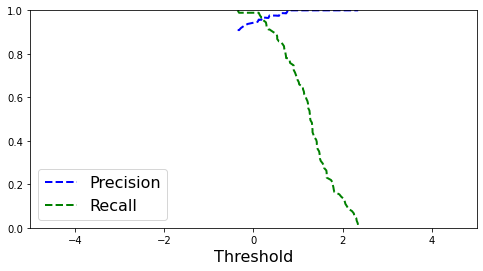

['03_output/01_eval_scores/evaluation_scores_SGDClassifier_dummy_toy_16.pkl']
>... Eval metrics pickle file successfully loaded for SGDClassifier and pixel resolution 16
>... Extracting Metrics into Dataframe of classifierSGDClassifier(random_state=42)
>... Displaying Precision-Recall Plot for SGDClassifier and pixel resolution 16


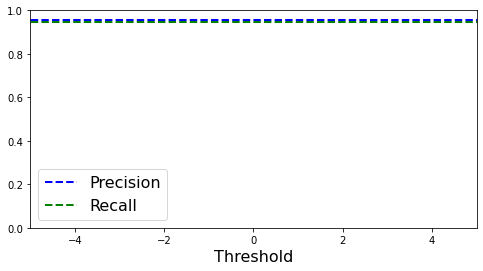


>... Ending showing evals for pixel resolution: 16. Run-time: 0.73 seconds.



>... Start showing evals for pixel resolution: 32.
Error Table for pixel resolution 32 not selected by user.
Confusion matrix for pixel resolution 32 not selected by user.
Eval metrics for pixel resolution 32 not selected by user.
['03_output/01_eval_scores/evaluation_scores_LinearSVC_dummy_toy_32.pkl']
>... Eval metrics pickle file successfully loaded for LinearSVC and pixel resolution 32
>... Extracting Metrics into Dataframe of classifierLinearSVC(max_iter=4000, random_state=42, tol=0.001)
>... Displaying Precision-Recall Plot for LinearSVC and pixel resolution 32


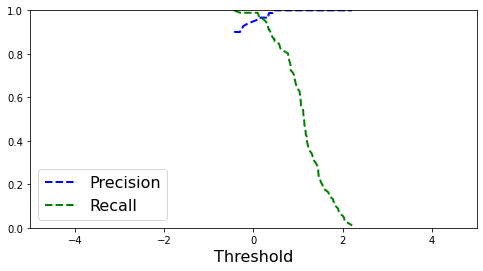

['03_output/01_eval_scores/evaluation_scores_SGDClassifier_dummy_toy_32.pkl']
>... Eval metrics pickle file successfully loaded for SGDClassifier and pixel resolution 32
>... Extracting Metrics into Dataframe of classifierSGDClassifier(random_state=42)
>... Displaying Precision-Recall Plot for SGDClassifier and pixel resolution 32


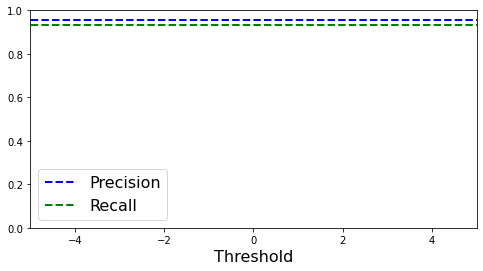


>... Ending showing evals for pixel resolution: 32. Run-time: 0.55 seconds.


In [236]:
# Also be aware of switch between full and toy data set in the beginning of the jupyter notebook!



####### Pixels #######
# Specify pixel resolutions
pixels = [16, 32] #, 48, 64



####### Classifiers #######
# import and define classifiers 
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm, tree
# from sklearn.neighbors import KNeighborsClassifier # KNN had several hours runtime and kernel always died before finising
from sklearn.linear_model import SGDClassifier#, LogisticRegression # LogReg hat several hours runtime and kernel always died before finishing
classifier_RandomForest = RandomForestClassifier(random_state=42)
classifier_DecTree = tree.DecisionTreeClassifier(random_state=42)
classifier_LinSVC = svm.LinearSVC(max_iter=4000, tol=1e-3, random_state=42) #linear as normal (c based) is impractical using large datasets
classifier_SGD = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
# classifier_KNN = KNeighborsClassifier(n_neighbors=1)
# classifier_LogReg = LogisticRegression(max_iter=2000, tol=1e-3,random_state=42)


# Combine classifiers to a list through which you can loop
classifiers= [ classifier_RandomForest, classifier_DecTree,classifier_LinSVC, classifier_SGD]



####### Actual running #######
load_train_eval(pixels, classifiers)
print("\n\n\n\n\n\n\n\n","##### BREAK #####","\n\n\n\n\n\n\n\n")
show_evals_pipeline(pixels, classifiers, error_table_switch=False, conf_matrix_switch=False, eval_metrics_switch=False, prec_recall_plot_switch =True )






>... Start showing evals for pixel resolution: 16.
Error Table for pixel resolution 16 not selected by user.
Confusion matrix for pixel resolution 16 not selected by user.
Eval metrics for pixel resolution 16 not selected by user.
['03_output/01_eval_scores/evaluation_scores_LinearSVC_dummy_toy_16.pkl']
>... Eval metrics pickle file successfully loaded for LinearSVC and pixel resolution 16
>... Extracting Metrics into Dataframe of classifierLinearSVC(max_iter=4000, random_state=42, tol=0.001)
>... Displaying Precision-Recall Plot for LinearSVC and pixel resolution 16


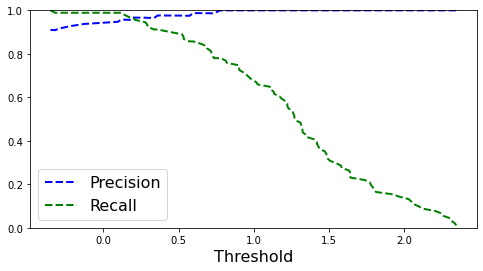

['03_output/01_eval_scores/evaluation_scores_SGDClassifier_dummy_toy_16.pkl']
>... Eval metrics pickle file successfully loaded for SGDClassifier and pixel resolution 16
>... Extracting Metrics into Dataframe of classifierSGDClassifier(random_state=42)
>... Displaying Precision-Recall Plot for SGDClassifier and pixel resolution 16


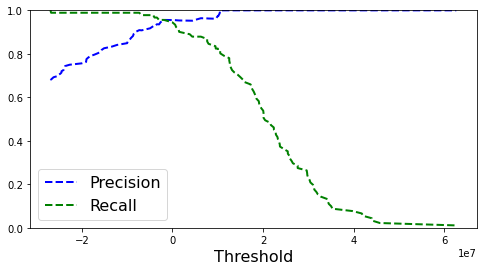


>... Ending showing evals for pixel resolution: 16. Run-time: 0.6 seconds.



>... Start showing evals for pixel resolution: 32.
Error Table for pixel resolution 32 not selected by user.
Confusion matrix for pixel resolution 32 not selected by user.
Eval metrics for pixel resolution 32 not selected by user.
['03_output/01_eval_scores/evaluation_scores_LinearSVC_dummy_toy_32.pkl']
>... Eval metrics pickle file successfully loaded for LinearSVC and pixel resolution 32
>... Extracting Metrics into Dataframe of classifierLinearSVC(max_iter=4000, random_state=42, tol=0.001)
>... Displaying Precision-Recall Plot for LinearSVC and pixel resolution 32


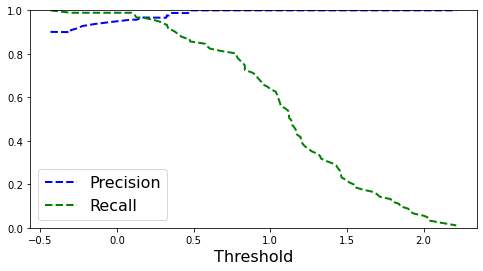

['03_output/01_eval_scores/evaluation_scores_SGDClassifier_dummy_toy_32.pkl']
>... Eval metrics pickle file successfully loaded for SGDClassifier and pixel resolution 32
>... Extracting Metrics into Dataframe of classifierSGDClassifier(random_state=42)
>... Displaying Precision-Recall Plot for SGDClassifier and pixel resolution 32


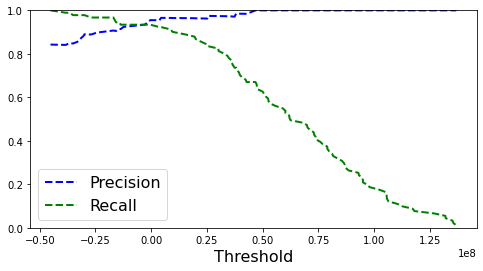


>... Ending showing evals for pixel resolution: 32. Run-time: 0.76 seconds.


In [239]:
show_evals_pipeline(pixels, classifiers, error_table_switch=False, conf_matrix_switch=False, eval_metrics_switch=False, prec_recall_plot_switch=True)
